In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras import layers, models
import tensorflow.keras as keras
import matplotlib.pyplot as plt

# So we dont have to use plt.show() every time:
%matplotlib inline

In [2]:
IMAGE_SIZE = 256
IMAGE_CHANNELS = 3
EPOCS = 10
BATCH_SIZE = 32

In [3]:
dataset = tf.keras.utils.image_dataset_from_directory(
    directory="dataset",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    labels='inferred',
    shuffle=True,
)

Found 4500 files belonging to 3 classes.


2022-07-18 14:58:51.892922: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-18 14:58:51.895423: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [4]:
CLASS_NAMES = dataset.class_names
print("Class names:", CLASS_NAMES)
print(len(dataset)*BATCH_SIZE)

Class names: ['Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_healthy']
4512


2022-07-18 14:59:00.077158: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Image batch shape: (32, 256, 256, 3)
Label batch as a tensor: tf.Tensor([1 1 1 2 0 1 0 1 1 2 1 0 1 1 1 2 2 0 0 0 2 1 2 1 2 2 1 2 0 2 2 1], shape=(32,), dtype=int32)
Label batch as numpy array: [1 1 1 2 0 1 0 1 1 2 1 0 1 1 1 2 2 0 0 0 2 1 2 1 2 2 1 2 0 2 2 1]
First image in batch raw tensor: tf.Tensor(
[[[154. 143. 139.]
  [189. 178. 174.]
  [193. 182. 178.]
  ...
  [182. 174. 172.]
  [181. 173. 171.]
  [181. 173. 171.]]

 [[174. 163. 159.]
  [165. 154. 150.]
  [134. 123. 119.]
  ...
  [180. 172. 170.]
  [178. 170. 168.]
  [177. 169. 167.]]

 [[143. 132. 128.]
  [179. 168. 164.]
  [160. 149. 145.]
  ...
  [181. 173. 171.]
  [178. 170. 168.]
  [177. 169. 167.]]

 ...

 [[187. 179. 177.]
  [172. 164. 162.]
  [196. 188. 186.]
  ...
  [206. 202. 203.]
  [208. 204. 205.]
  [211. 207. 208.]]

 [[190. 182. 180.]
  [160. 152. 150.]
  [221. 213. 211.]
  ...
  [204. 200. 201.]
  [206. 202. 203.]
  [208. 204. 205.]]

 [[206. 198. 196.]
  [177. 169. 167.]
  [220. 212. 210.]
  ...
  [201. 197. 198.]

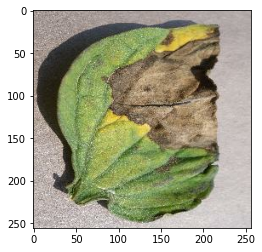

In [5]:
for image_batch, label_batch in dataset.take(1): # First batch
    print("Image batch shape:", image_batch.shape)
    print("Label batch as a tensor:", label_batch)
    print("Label batch as numpy array:", label_batch.numpy())
    print("First image in batch raw tensor:", image_batch[0])
    print("First image visualization:")
    plt.imshow(image_batch[0].numpy().astype(np.uint8))
    break

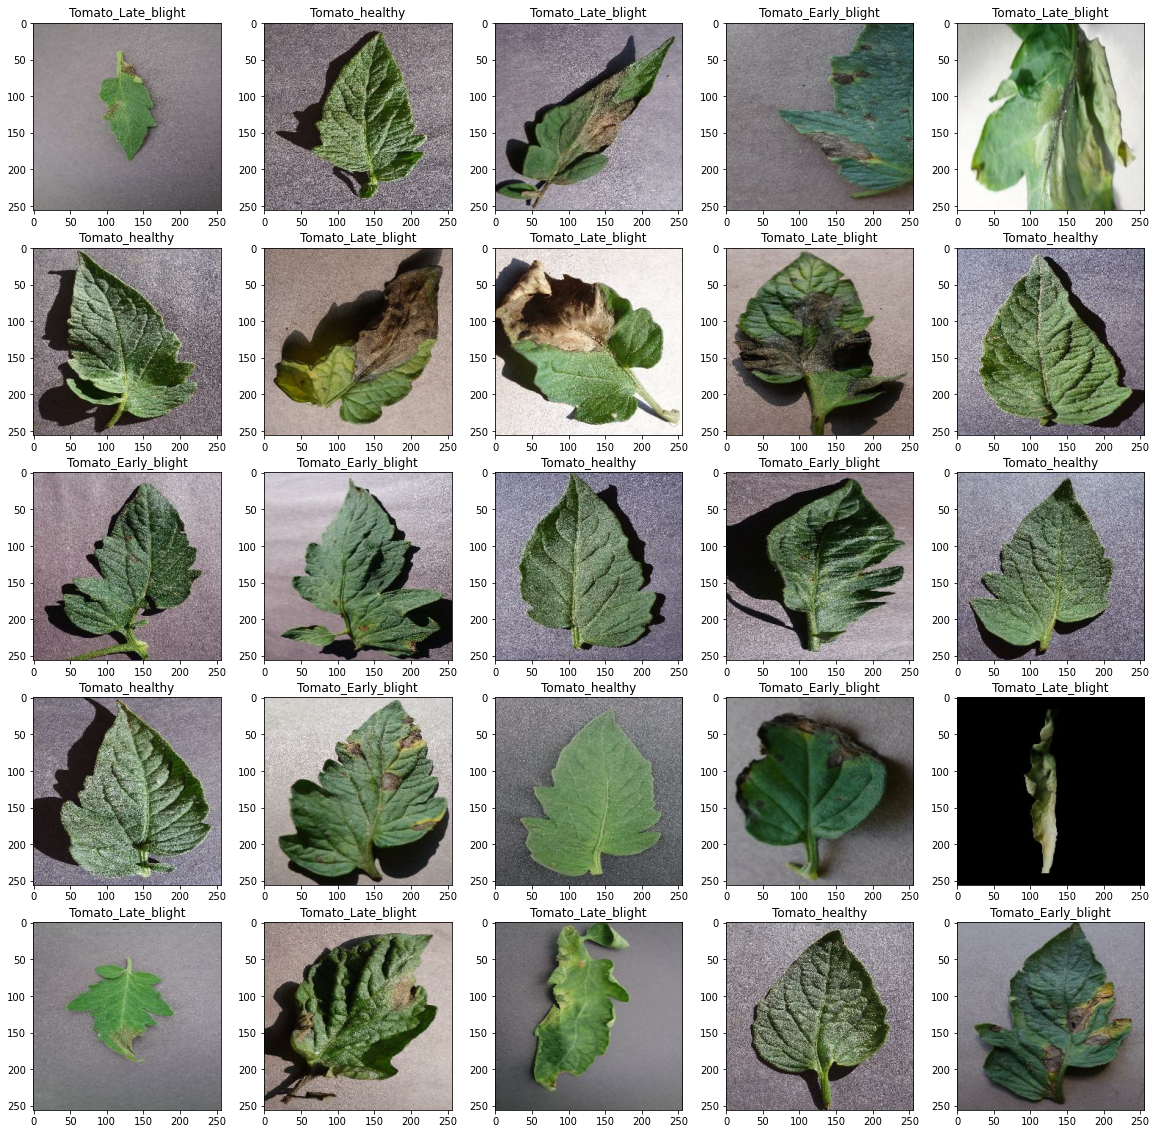

In [6]:

# plotting first 25 images in the batch
plt.figure(figsize=(20, 20))
for image_batch, label_batch in dataset.take(1):
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(image_batch[i].numpy().astype(np.uint8))
        plt.title(CLASS_NAMES[label_batch[i].numpy()])

In [7]:
def get_dataset_partitions_tf(dataset, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    """
    Returns a tuple of (train_dataset, val_dataset, test_dataset)
    """
    ds_size = len(dataset)

    # Shuffle the dataset
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=42)
    
    train_take = int(train_split * ds_size)
    val_take = int(val_split * ds_size)
    test_take = int(test_split * ds_size)

    train_dataset = dataset.take(train_take)
    val_dataset = dataset.skip(train_take).take(val_take)
    test_dataset = dataset.skip(train_take + val_take)

    return train_dataset, val_dataset, test_dataset


In [8]:
train_dataset, val_dataset, test_dataset = get_dataset_partitions_tf(dataset)

In [9]:
# Cache, shuffle and prefetch the datasets
train_dataset = train_dataset.cache().shuffle(1000).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(1000).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(tf.data.experimental.AUTOTUNE)


In [12]:
# resize and rescale layer:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255),
])

# Data augmentation layer:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [13]:
# Model building:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(CLASS_NAMES), activation='softmax')
])

model.build(input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS))

In [14]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_2 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 128)        

In [15]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [16]:
history = model.fit(
    train_dataset,
    epochs=EPOCS,
    validation_data=val_dataset,
    verbose=1
)

Epoch 1/10
112/112 [==============================] - 222s 2s/step - loss: 0.7037 - accuracy: 0.6962 - val_loss: 0.4067 - val_accuracy: 0.8438
Epoch 2/10
112/112 [==============================] - 220s 2s/step - loss: 0.3952 - accuracy: 0.8289 - val_loss: 0.4080 - val_accuracy: 0.7991
Epoch 3/10
112/112 [==============================] - 221s 2s/step - loss: 0.2786 - accuracy: 0.8763 - val_loss: 0.2322 - val_accuracy: 0.8929
Epoch 4/10
112/112 [==============================] - 217s 2s/step - loss: 0.2543 - accuracy: 0.8961 - val_loss: 0.2453 - val_accuracy: 0.9040
Epoch 5/10
112/112 [==============================] - 225s 2s/step - loss: 0.2518 - accuracy: 0.8992 - val_loss: 0.3208 - val_accuracy: 0.8616
Epoch 6/10
112/112 [==============================] - 221s 2s/step - loss: 0.1867 - accuracy: 0.9269 - val_loss: 0.1621 - val_accuracy: 0.9487
Epoch 7/10
112/112 [==============================] - 218s 2s/step - loss: 0.1804 - accuracy: 0.9339 - val_loss: 0.2100 - val_accuracy: 0.9018

In [17]:
scores = model.evaluate(test_dataset)

15/15 [==============================] - 10s 359ms/step - loss: 0.1334 - accuracy: 0.9487


In [23]:
import os
model_version=max([int(i) for i in os.listdir("models") + [0]])+1
model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/1/assets
